# Simulation of the transmon pocket

This notebook shows how to design a transmon pocket (single pad design) in qiskit metal. The notebook only need **TransmonPocket_Single** function from a relative path '../../resources'.

## Draw the single pad design with connected CPW resonators

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
#This imports the necessary path to draw the single pad transmon design. 
import sys
sys.path.append('../../resources')
from single_pad_transmon_pocket import TransmonPocket_Single

import shapely
import warnings
from shapely.errors import ShapelyDeprecationWarning
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning)

In [3]:
from qiskit_metal import designs, draw
from qiskit_metal import MetalGUI, Dict, Headings

In [4]:
from qiskit_metal.qlibrary.terminations.short_to_ground import ShortToGround
from qiskit_metal.qlibrary.terminations.open_to_ground import OpenToGround

from qiskit_metal.qlibrary.tlines.mixed_path import RouteMixed

In [5]:
design = designs.DesignPlanar()
gui = MetalGUI(design)

In [6]:
design.variables['cpw_width'] = '15 um'
design.variables['cpw_gap'] = '9 um'

### Draw the single pad transmon

In [12]:
design.overwrite_enabled = True #This makes it possible to edit the designs later on. 

design.delete_all_components()

options = dict(pad_width = '250um',
pocket_width = '300um',
pad_pocket_distance_top = '60um',
pos_x = '0',
pad_height = '200um',
pos_y = '0',
connection_pads = dict(
    a = dict(loc_W  = 1, 
             loc_H =  1, 
             pad_gap = '10um',
             pad_height = '20um',
             pad_width = '100um',
             pad_cpw_extent =  '10um',
             pocket_rise = '0um',
             cpw_extend = '5um')))

q1 = TransmonPocket_Single(design,'Q1',options = options)

gui.rebuild()
gui.zoom_on_components(['Q1'])

### Draw the end pins and the CPW

In [13]:
#This is a function to generate needed pins for CPW drawing. 
import numpy as np
from collections import OrderedDict

def pins_for_spiral(radius,gap,n,dis = (0,0)):
    spiral_list = OrderedDict()
    x,y = dis
    for step in range(n):
        point_value = radius / 2 + step * (0 + gap)
        spiral_list[step*4] = np.array([x+point_value, y-point_value])
        spiral_list[step*4+1] = np.array([x-point_value, y-point_value])
        spiral_list[step*4+2] = np.array([x-point_value, y+point_value])
        spiral_list[step*4+3] = np.array([x+point_value + (0 + gap), y+point_value])

    point_value = radius / 2 + (step + 1) * (0 + gap)
    # spiral_list[step*4+4] = np.array([-point_value, -point_value])
    return(spiral_list)

In [14]:
anchors = pins_for_spiral(0.4,0.1,2,dis = (0,0))
print(anchors)

OrderedDict([(0, array([ 0.2, -0.2])), (1, array([-0.2, -0.2])), (2, array([-0.2,  0.2])), (3, array([0.3, 0.2])), (4, array([ 0.3, -0.3])), (5, array([-0.3, -0.3])), (6, array([-0.3,  0.3])), (7, array([0.4, 0.3]))])


In [15]:
options = Dict(total_length='4 mm',
        hfss_wire_bonds = True,
        q3d_wire_bonds = True,
        fillet='20 um',
        lead = dict(start_straight='20um', end_straight = '0um'),
        anchors = anchors,
        pin_inputs=Dict(
            start_pin=Dict(component='Q1', pin='a'),
            end_pin=Dict(component='end', pin='short')), )

In [18]:
stg = ShortToGround(design,'end',options = dict(pos_x = '0.5mm',pos_y = '0.5mm',orientation = '90'))
gui.rebuild()
gui.highlight_components(['end'])

In [19]:

qa = RouteMixed(design, 'cpw_1', options)

gui.rebuild()
gui.autoscale()

In [20]:
def draw_CPW(short=True):
    if short:
        options = Dict(total_length='5 mm',
            hfss_wire_bonds = True,
            q3d_wire_bonds = True,
            fillet='20 um',
            lead = dict(start_straight='20um', end_straight = '0um'),
            anchors = anchors,
            pin_inputs=Dict(
                start_pin=Dict(component='Q1', pin='a'),
                end_pin=Dict(component='end', pin='short')), )
        stg = ShortToGround(design,'end',options = dict(pos_x = '0.5mm',pos_y = '0.5mm',orientation = '90'))
        qa = RouteMixed(design, 'cpw_1', options)
    else:
        options = Dict(total_length='5 mm',
            hfss_wire_bonds = True,
            q3d_wire_bonds = True,
            fillet='20 um',
            lead = dict(start_straight='20um', end_straight = '0um'),
            anchors = anchors,
            pin_inputs=Dict(
                start_pin=Dict(component='Q1', pin='a'),
                end_pin=Dict(component='end', pin='open')), )
        otg = OpenToGround(design,'end',options = dict(pos_x = '0.5mm',pos_y = '0.5mm',orientation = '90'))
        qa = RouteMixed(design, 'cpw_1', options)
    gui.rebuild()
    gui.autoscale()

# Simulations

## Capacitance Matrix Calculation

Note that when we calculate capacitance matrix, we need to ``approximate" that the end pins of the CPW is not grounded to get the capacitance coupling. Thus we need to modify the designs above to get the desired capacitance matrix. 

In [21]:
draw_CPW(short=False)

In [22]:
from qiskit_metal.analyses.quantization import LOManalysis
c1 = LOManalysis(design, "q3d")

In [23]:
c1.sim.setup.min_passes  = 1
c1.sim.setup.max_passes = 5
print(c1.sim.setup)

{'name': 'Setup', 'reuse_selected_design': True, 'reuse_setup': True, 'freq_ghz': 5.0, 'save_fields': False, 'enabled': True, 'max_passes': 5, 'min_passes': 1, 'min_converged_passes': 2, 'percent_error': 0.5, 'percent_refinement': 30, 'auto_increase_solution_order': True, 'solution_order': 'High', 'solver_type': 'Iterative'}


In [24]:
c1.sim.run(components=['Q1','cpw_1','end'])#, open_terminations=[('end', 'a')])#, ('Q1', 'bus1'), ('Q1', 'bus2')])
c1.sim.capacitance_matrix 

c1.sim._get_results_from_renderer()
c_mat = c1.sim.capacitance_matrix

INFO 12:43PM [connect_project]: Connecting to Ansys Desktop API...
INFO 12:43PM [load_ansys_project]: 	Opened Ansys App
INFO 12:43PM [load_ansys_project]: 	Opened Ansys Desktop v2022.2.0
INFO 12:43PM [load_ansys_project]: 	Opened Ansys Project
	Folder:    C:/Users/slab/Documents/Ansoft/
	Project:   Project10
INFO 12:43PM [connect_design]: No active design found (or error getting active design).
INFO 12:43PM [connect]: 	 Connected to project "Project10". No design detected
INFO 12:43PM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
WARNING 12:43PM [connect_setup]: 	No design setup detected.
WARNING 12:43PM [connect_setup]: 	Creating Q3D default setup.
INFO 12:43PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 12:43PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 12:43PM [analyze]: Analyzing setup Setup
INFO 12:43PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Tem

In [25]:
c_mat

,a_connector_pad_Q1,g_wb,pad_top_Q1
a_connector_pad_Q1,664.94290,-642.04927,-18.99496
g_wb,-642.04927,784.61722,-77.15734
pad_top_Q1,-18.99496,-77.15734,98.09654


In the capacitance matrix above, the ground plane is named "g_wb" The big metal pad in the junction pocket is called "pad_top_Q1" The CPW is connected with the connector pad, thus its name is "a_connector_pad"

In [26]:
c1.clear_data()

## EPR Analysis

In [27]:
import numpy as np
from qiskit_metal.analyses.quantization import EPRanalysis

In [28]:
hfss.clean_active_design()

NameError: name 'hfss' is not defined

INFO 12:44PM [connect_project]: Connecting to Ansys Desktop API...
INFO 12:44PM [load_ansys_project]: 	Opened Ansys App
INFO 12:44PM [load_ansys_project]: 	Opened Ansys Desktop v2022.2.0
INFO 12:44PM [load_ansys_project]: 	Opened Ansys Project
	Folder:    C:/Users/slab/Documents/Ansoft/
	Project:   Project10
INFO 12:44PM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
INFO 12:44PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 12:44PM [connect]: 	Connected to project "Project10" and design "Design_q3d" 😀 

12:44PM 09s WARNING [activate_ansys_design]: The design_name=readout was not in active project.  Designs in active project are: 
['Design_q3d'].  A new design will be added to the project.  
INFO 12:44PM [connect_design]: 	Opened active design
	Design:    readout [Solution type: Eigenmode]
WARNING 12:44PM [connect_setup]: 	No design setup detected.
WARNING 12:44PM [connect_setup]: 	Creating eigenmode default setup.
I

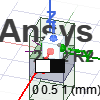

INFO 12:44PM [analyze]: Analyzing setup Setup



Number of eigenmodes to find             = 2
Number of simulation passes              = 40
Convergence freq max delta percent diff  = 0.1



12:59PM 36s CRITICAL [_qt_message_handler]: line: 0, func: None(), file: None  CRITICAL: QEventDispatcherWin32::wakeUp: Failed to post a message (Not enough quota is available to process this command.)



In [29]:

draw_CPW()
# design.delete_component('Q1')
eig_res = EPRanalysis(design, "hfss")

hfss = eig_res.sim.renderer
hfss.start()

hfss.activate_ansys_design('readout','eigenmode')

hfss.render_design(['cpw_1','Q1','end'],[])
hfss.save_screenshot()

setup = hfss.pinfo.setup
setup.passes = 40
setup.min_converged = 9
setup.n_modes = 2

print(f"""
Number of eigenmodes to find             = {setup.n_modes}
Number of simulation passes              = {setup.passes}
Convergence freq max delta percent diff  = {setup.delta_f}
""")

# Next 2 lines are counterinuitive, since there is no junction in this resonator.
# However, these are necessary to make pyEPR work correctly. Please do note delete
hfss.pinfo.design.set_variable('Lj', '10 nH')
hfss.pinfo.design.set_variable('Cj', '0 fF')

setup.analyze()

In [57]:
eig_res.get_frequencies()

Design "readout" info:
	# eigenmodes    2
	# variations    1
Design "readout" info:
	# eigenmodes    2
	# variations    1


Freq. (GHz)  Quality Factor
variation mode                             
0         0        6.344379             inf
          1        7.003760             inf

In [68]:
eig_res.sim.convergence_t, eig_res.sim.convergence_f, _ = hfss.get_convergences()
eig_res.sim.plot_convergences()

12:01PM 44s INFO [get_f_convergence]: Saved convergences to c:\Users\slab\Desktop\Qiskit_metal_tutorial\tutorials\4 Analysis\A. Core - EM and quantization\hfss_eig_f_convergence.csv
INFO 12:01PM [__del__]: Disconnected from Ansys HFSS


11:29AM 10s WARNING [plot_ansys_fields]: This method is deprecated. Change your scripts to use plot_fields()


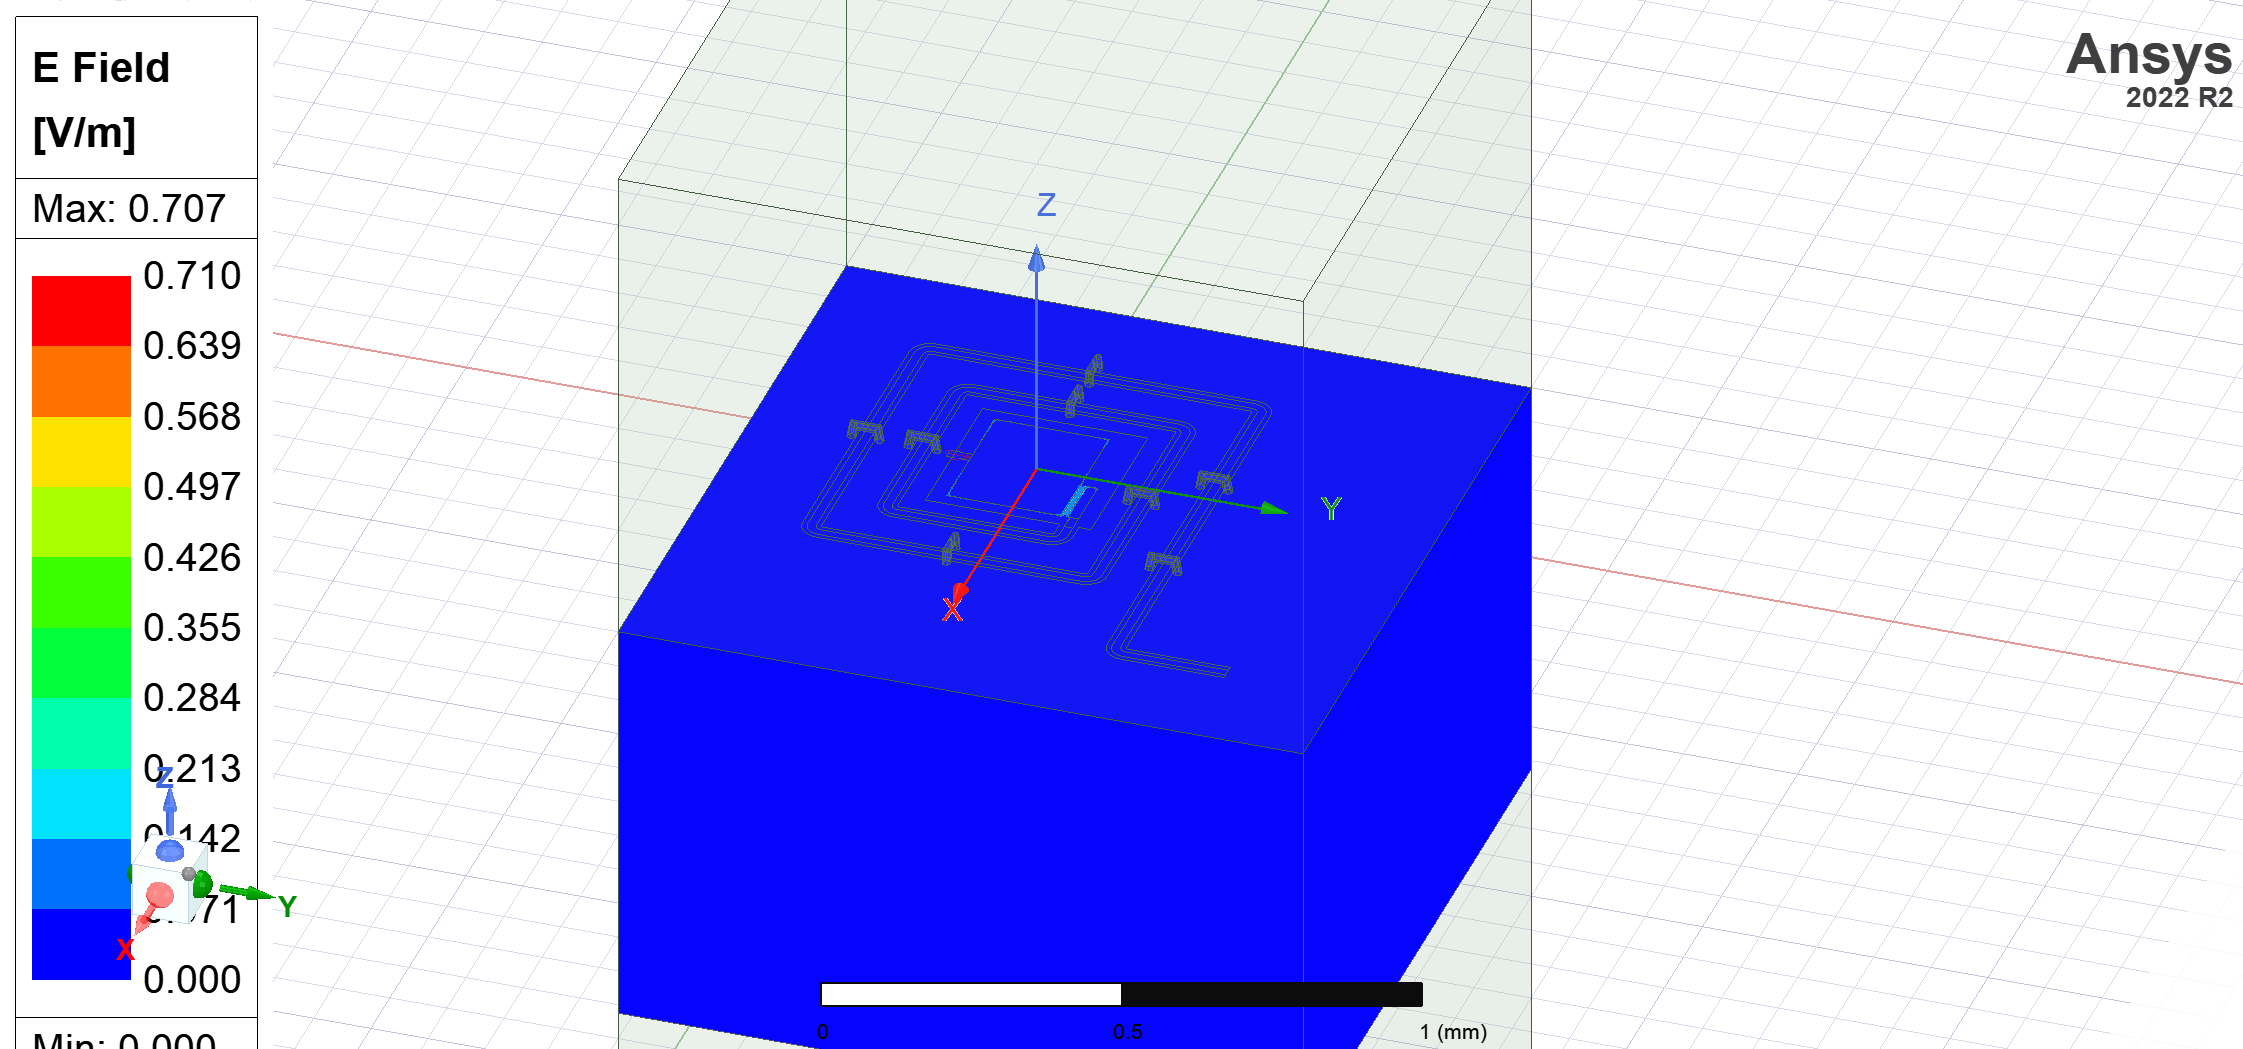

WindowsPath('c:/Users/slab/Desktop/Qiskit_metal_tutorial/tutorials/4 Analysis/A. Core - EM and quantization/ansys.png')

In [59]:
hfss.modeler._modeler.ShowWindow()
hfss.plot_ansys_fields('main')
hfss.save_screenshot()

In [60]:
hfss.clear_fields(['Mag_E1'])

In [61]:
hfss.set_mode(2, "Setup")

INFO 11:29AM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)


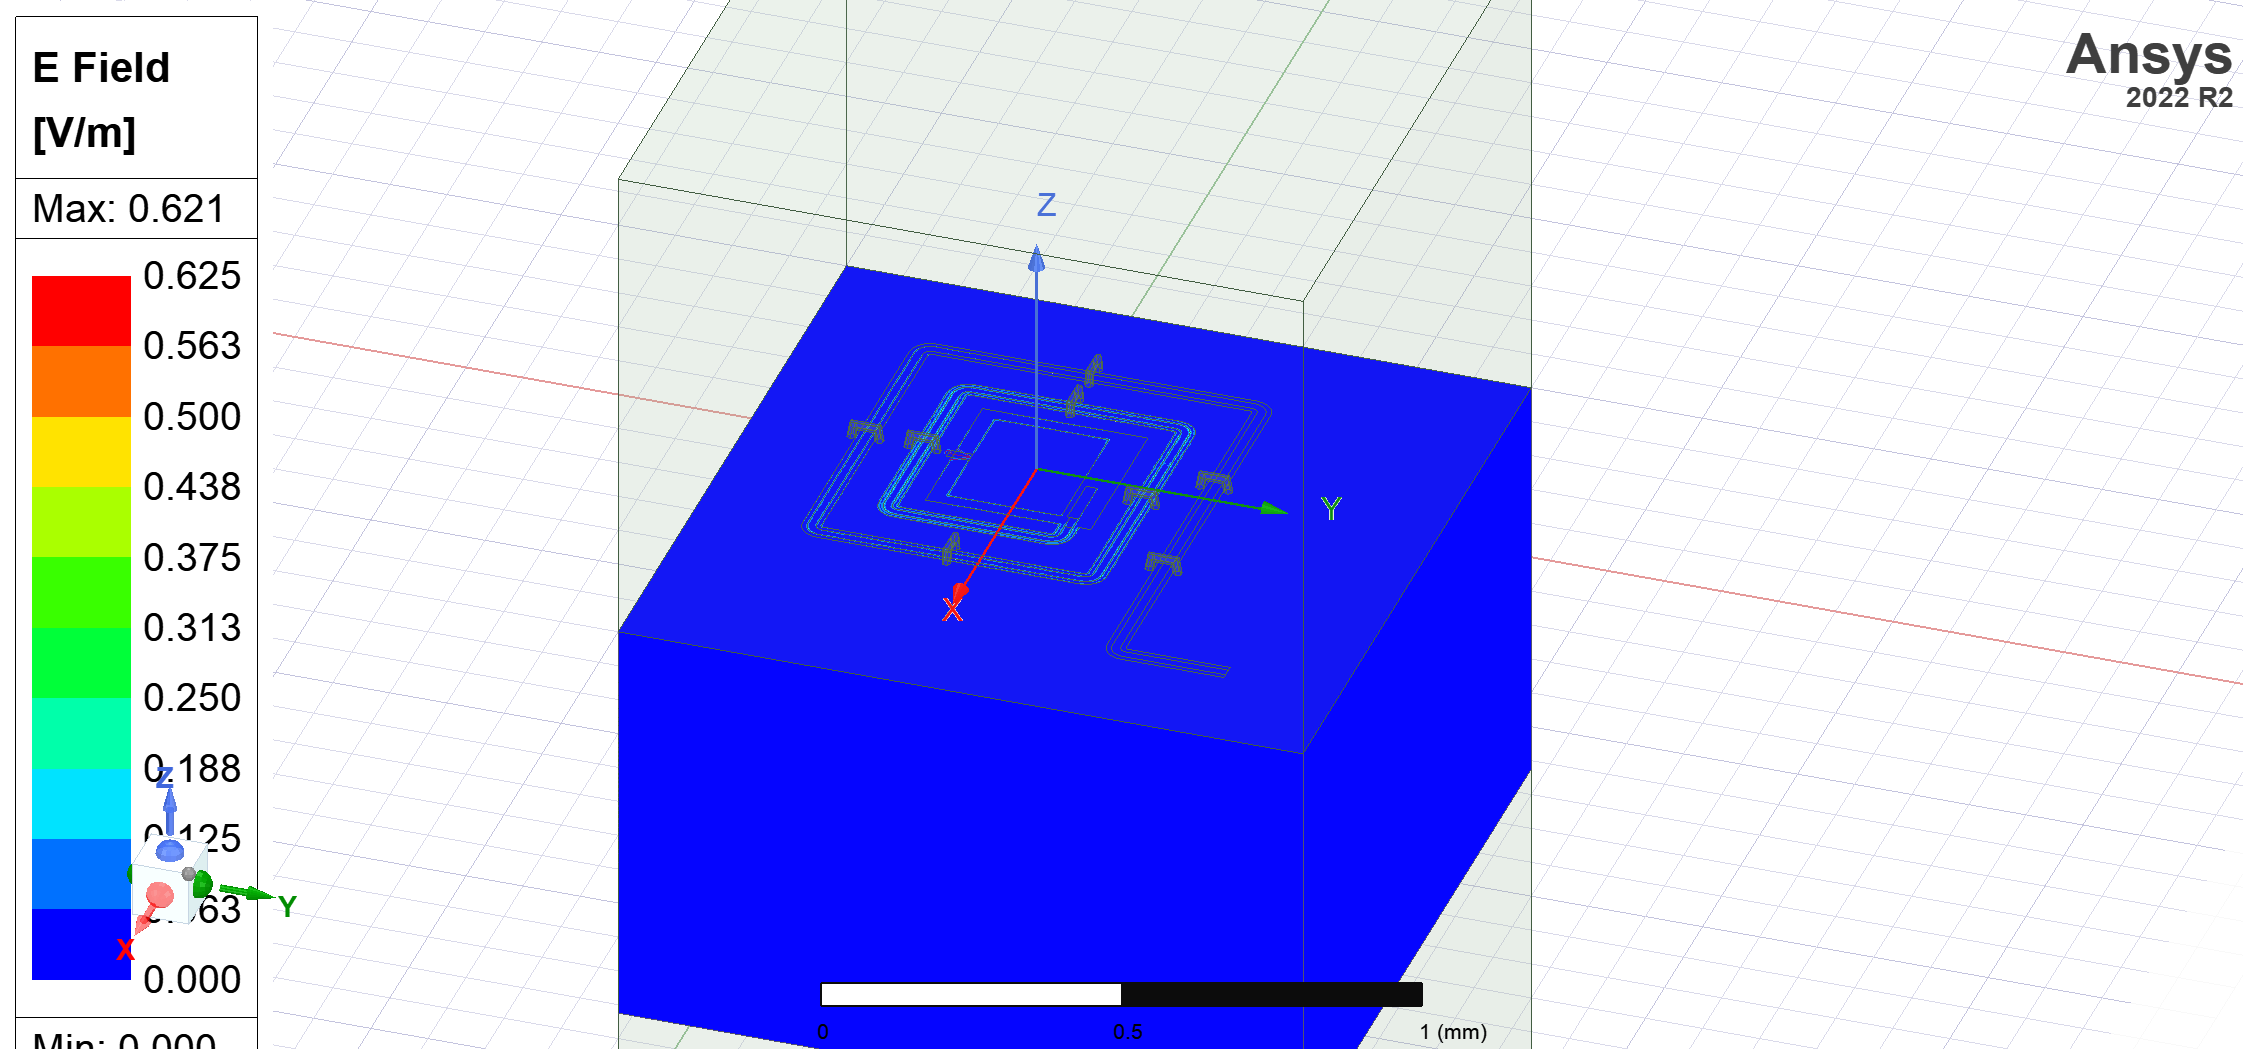

WindowsPath('c:/Users/slab/Desktop/Qiskit_metal_tutorial/tutorials/4 Analysis/A. Core - EM and quantization/ansys.png')

In [62]:
hfss.modeler._modeler.ShowWindow()
hfss.plot_fields('main')
hfss.save_screenshot()

## Save Design to GDS

In [63]:
a_gds = design.renderers.gds

In [64]:
a_gds.options

{'short_segments_to_not_fillet': 'True',
 'check_short_segments_by_scaling_fillet': '2.0',
 'gds_unit': 0.001,
 'ground_plane': 'True',
 'negative_mask': {'main': []},
 'fabricate': 'False',
 'corners': 'circular bend',
 'tolerance': '0.00001',
 'precision': '0.000000001',
 'width_LineString': '10um',
 'path_filename': '../resources/Fake_Junctions.GDS',
 'junction_pad_overlap': '5um',
 'max_points': '199',
 'cheese': {'datatype': '100',
  'shape': '0',
  'cheese_0_x': '25um',
  'cheese_0_y': '25um',
  'cheese_1_radius': '100um',
  'view_in_file': {'main': {1: True}},
  'delta_x': '100um',
  'delta_y': '100um',
  'edge_nocheese': '200um'},
 'no_cheese': {'datatype': '99',
  'buffer': '25um',
  'cap_style': '2',
  'join_style': '2',
  'view_in_file': {'main': {1: True}}},
 'bounding_box_scale_x': '1.2',
 'bounding_box_scale_y': '1.2'}

In [65]:
a_gds.options['path_filename'] = '../resources/Fake_Junctions.GDS'

In [67]:

a_gds.options['short_segments_to_not_fillet'] = 'False'
a_gds.export_to_gds('One pad design.gds')

11:49AM 42s WARNING [_import_junction_gds_file]: Not able to find file:"../resources/Fake_Junctions.GDS".  Not used to replace junction. Checked directory:"c:\Users\slab\Desktop\Qiskit_metal_tutorial\tutorials\4 Analysis\resources".


1

The rest of the notebook is just a scratch paper :D

In [130]:
q3d.clean_active_design()

{'name': 'Setup',
 'reuse_selected_design': True,
 'reuse_setup': True,
 'freq_ghz': 5,
 'max_delta_s': 0.1,
 'max_passes': 10,
 'min_passes': 1,
 'min_converged': 1,
 'pct_refinement': 30,
 'basis_order': 1,
 'vars': {'Lj': '10 nH', 'Cj': '0 fF'},
 'sweep_setup': {'name': 'Sweep',
  'start_ghz': 2.0,
  'stop_ghz': 8.0,
  'count': 101,
  'step_ghz': None,
  'type': 'Fast',
  'save_fields': False}}

In [51]:
import numpy as np
import scipy.linalg as la
import qutip as q
import astropy.units as u
import astropy.constants as con

class Single_Transmon_Circuit:
    ## Default constant
    eq = 1.602e-19*u.C 
    epsilon = con.eps0
    h = 6.636/10**34
    hbar = con.hbar
    kb = con.k_B
    Tc = 1.2
    delta = 1.764*kb*Tc
    phi0 = con.h/2/eq
    dielectric = 9.34*epsilon
    def __init__(self,cap_mat,pad_name,CPW_name,ground_plane_name = 'ground_main_plane') -> None:
        self.c_couple = -cap_mat[pad_name][CPW_name]*u.fF
        self.c_to_ground = cap_mat[pad_name][pad_name]
        self.c_CPW = cap_mat[CPW_name][CPW_name]

In [54]:
Single_Transmon_Circuit(c_mat,'pad_top_Q1','n_spiral_spiral')